# Advanced Pandas

Here we will touch on some of the most complex areas of Pandas, continuing from a number of the Intermediate topics mentioned previously, to give you as full of an experience as possible using `pandas`.

In [1]:
import pandas as pd
import numpy as np

## `pandas.melt`: From wide to long

A number of the packages require data to exist in *long-form*, this often means that columns contain duplicates and is memory and disk intensive. It is far more common to keep data in wide-form. However when we need to convert data that has many similar-like columns into *long-form*, `pd.melt` is one of the best functions in Pandas to achieve this.

Take the `cdystonia` dataset for example.

In [2]:
cdystonia = pd.read_csv("datasets/cdystonia.csv")
print(cdystonia.shape)
cdystonia.head(3)

(631, 9)


,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24


Using aforementioned methods, we can expand out the `twstrs` response column to be multiple columns using a *pivot*. Here we use the `week` as the columns (identical to observation `obs`), and use the set difference to eliminate, keeping all the other columns available.

In [3]:
cdystonia_wide = cdystonia.pivot_table("twstrs", index=cdystonia.columns.difference(["twstrs","obs","week"]).tolist(), columns="week")
print(cdystonia_wide.shape)
cdystonia_wide.head()

(109, 6)


week                               0     2     4     8     12    16
age id patient sex site treat                                      
26  8  75      F   7    Placebo  42.0  48.0  26.0  37.0  37.0  43.0
31  10 22      M   2    Placebo  44.0  40.0  32.0  36.0  42.0  43.0
34  11 90      F   8    10000U   49.0  25.0  30.0  49.0  55.0  58.0
35  4  50      F   5    10000U   50.0  50.0   NaN  46.0  50.0  57.0
    12 38      M   3    5000U    29.0  42.0  35.0  24.0  29.0  42.0

You can see that $(631,9)$ is substantially larger than $(109,6)$ in terms of dimensional size. By specifying the columns we want to keep as identifiers, `pd.melt` selects every other column and collapses it into a single column, that we name back as `twstrs`:

In [4]:
cdystonia_long = pd.melt(cdystonia_wide.reset_index(), id_vars=["age","id","patient","sex","site","treat"], value_name="twstrs", var_name="week")
cdystonia_long.head(3)

,age,id,patient,sex,site,treat,week,twstrs
0,26,8,75,F,7,Placebo,0,42.0
1,31,10,22,M,2,Placebo,0,44.0
2,34,11,90,F,8,10000U,0,49.0


## Vectorized String Operations

One strength of Python is its relative ease in handling and manipulating string data. Pandas builds on this and provides a comprehensive set of vectorized string operations that become an essential piece of the type of munging required when working with (read: cleaning up) real-world data. In this section, we'll walk through some of the Pandas string operations, and then take a look at using them to partially clean up a very messy dataset of recipes collected from the Internet.

If we recall from NumPy, one of the key advantages was the *vectorization* of mathematical operations, such as this:

In [5]:
x=np.array([2,3,5,7,11,13])
x**2

array([  4,   9,  25,  49, 121, 169])

Whereas for arrays of strings, NumPy does not provide such simple access, and we have to fall back to using a Pythonic list comprehension:

In [6]:
x=np.array(['peter','Paul','mary','guido'])
[s.capitalize() for s in x]

['Peter', 'Paul', 'Mary', 'Guido']

In [7]:
x.capitalize()

AttributeError: 'numpy.ndarray' object has no attribute 'capitalize'

In addition, this Pythonic method will break in cases where there is missing data:

In [8]:
x=np.array(['peter','Paul',None,'mary','guido'])
[s.capitalize() for s in x]

AttributeError: 'NoneType' object has no attribute 'capitalize'

Pandas includes features to address both this need for vectorized string operations and for correctly handling missing data via the `str` attribute of `pd.Series` and `pd.Index` objects containing string information. 

In [9]:
names = pd.Series(["Jeff", "alan", "Steve", "gUIDO", None, "job", None])
names

0     Jeff
1     alan
2    Steve
3    gUIDO
4     None
5      job
6     None
dtype: object

We can now call a single method to capitalize the entries, as follows:

In [10]:
names.str.capitalize()

0     Jeff
1     Alan
2    Steve
3    Guido
4     None
5      Job
6     None
dtype: object

### Available methods in `pandas.str`

Nearly all of the Python built-in string methods are mirrored in Pandas vectorized string methods, here is a tabular list:

| & | & | &  | &|
|------- | ----------- | ----------- | ------------- |
| `len()` | `lower()` | `translate()` | `islower()` |
| `ljust()` | `rjust()` | `lower()` | `upper()` | 
| `startswith()` | `endswith()` | `find()` | `isnumeric()` |
| `center()` | `rfind()` | `isalnum()` | `isdecimal()` | 
| `zfill()` | `index()` | `isalpha()` | `split()` |
| `strip()` | `rindex()` | `isdigit()` | `rsplit()` |
| `rstrip()` | `capitalize()` | `isspace()` | `partition()` |
| `lstrip()` | `swapcase()` | `istitle()` | `rpartition()` |

Note that there are variable return values, for instance `lower()` returns a string, but `len()` returns an integer, `startswith()` returns a boolean value, etc.

### Additional method using regular expressions

This is where the true power of Pandas comes in: not only can we do direct matching and string manipulation, but also provide functionality to examine the content of each element using a regular expression. Some of the below functions we can use are:

| **Method** | **Description** |
| ---------- | -------------------------------- |
| `match()` | Calls `re.match()` on each element, returning a boolean |
| `extract()` | Calls `re.extract()` on each element, returning matched groups as strings |
| `findall()` | Calls `re.findall()` on each element |
| `replace()` | Replaces occurences of pattern with some other string |
| `contains()` | Calls `re.search()` on each element, returning a boolean |
| `count()` | Count occurrences of pattern |
| `split()` | Calls `str.split()`, but accepts regular expressions |
| `rsplit()` | Calls `str.rsplit()` but accepts regular expressions |

With these, we have a wide range of interesting operations. For example, we can extract the first name from each by asking for a contiguous group of characters at the beginning of the element:

In [11]:
monte = pd.Series(['Graham Chapman', 'John Cleese', 'Terry Gilliam',
                   'Eric Idle', 'Terry Jones', 'Michael Palin'], name="names")

In [12]:
monte.str.extract("([A-Za-z]+)", expand=False)

0     Graham
1       John
2      Terry
3       Eric
4      Terry
5    Michael
Name: names, dtype: object

Note that if we return `expand=True`, we return a 1-D dataframe, else we get a `pd.Series`. Or we could do something more complicated, like finding all the names that start and end with a consonant, make use of the start-of-string (^) and end-of-string (\$) regular expression characters:

In [13]:
monte.str.findall(r"^[^AEIOU].*[^aeiou]$")

0    [Graham Chapman]
1                  []
2     [Terry Gilliam]
3                  []
4       [Terry Jones]
5     [Michael Palin]
Name: names, dtype: object

### Miscallaneous methods

Finally, there are a number of convenient operations which Pandas uniquely provides that can be invaluable when *function chaining*:

| **Method** | **Description** |
| ----------- | ----------------------------- |
| `get()` | Index each element |
| `slice()` | Slice each element |
| `slice_replace()` | Replace slice in each element with passed value |
| `cat()` | Concatenate strings |
| `repeat()` | Repeat values |
| `normalize()` | Return a unicode form of the string |
| `pad()` | Add whitespace to the left, right or both sides of a string |
| `wrap()` | Split long strings into lines of length less than a given width |
| `join()` | Join strings in each element of the Series with passed separator |
| `get_dummies()` | Extract dummy variables as DataFrame |

### Vectorized item access and slicing

The `get()` and `slice()` operations, enable vectorized element access from each array. For example:

In [14]:
monte.str[:3]

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
Name: names, dtype: object

Is equivalent to:

In [15]:
monte.str.slice(0,3)

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
Name: names, dtype: object

In [16]:
monte.str.split(" ", expand=True)

,0,1
0,Graham,Chapman
1,John,Cleese
2,Terry,Gilliam
3,Eric,Idle
4,Terry,Jones
5,Michael,Palin


### Indicator Variables

Another method that requires a bit of extra explanation is the `get_dummies()` method. This is useful when your data has a column containing some sort of coded indicator. For example, we might have a dataset that contains information in the form of codes, such as A="born in America," B="born in the United Kingdom," C="likes cheese," D="likes spam":

In [17]:
info=pd.Series(["B|C|D","B|D","A|C","B|D","B|C", "B|C|D"])
info.name="info"

In [18]:
full_monte = pd.concat([monte, info],axis=1)

The `get_dummies` routine lets you split out indicator variables into a new DataFrame:

In [19]:
full_monte["info"].str.get_dummies("|")

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1


## Categorical Types

Categoricals are a pandas data type corresponding to categorical variables, such as from statistics. A categorical variable takes on a limited, fixed, number of possible values. Examples include gender, blood type, country or rating. Categorical data may be ordered, but numerical operations are not possible on them.

All of the values in categorical data are either in categories or `np.nan`. Order is defined by the order of *categories*, not the lexical order of the values. Using a categorical data type has a number of **advantages**:

- A string variable consisting of only a few different values can be *efficiently* stored internally as each string is represented by an integer, and only unique strings are in the categories array.
- Sorting through an ordered categorical variable is substantially faster.
- Provides valuable metadata to Pandas when it comes to smart plotting, operations, etc.

Much of this material is drawn from the Pandas documentation, which is extensive and found [here](https://pandas.pydata.org/pandas-docs/stable/categorical.html). 

In [20]:
c = pd.Categorical(['a', 'b', 'b', 'c', 'a', 'b', 'a', 'a', 'a', 'c'])
c

[a, b, b, c, a, b, a, a, a, c]
Categories (3, object): [a, b, c]

In [21]:
c.describe()

,counts,freqs
categories,,
a,5,0.5
b,3,0.3
c,2,0.2


In [22]:
c.codes

array([0, 1, 1, 2, 0, 1, 0, 0, 0, 2], dtype=int8)

You can provide information as to the ordering of the categories:

In [23]:
c.as_ordered()

[a, b, b, c, a, b, a, a, a, c]
Categories (3, object): [a < b < c]

In [24]:
c.dtype

CategoricalDtype(categories=['a', 'b', 'c'], ordered=False)

Converting an existing 'object' feature into a category:

In [25]:
s = pd.Series(["air", "water", "fire", "fire", "water", "earth", "fire", "fire", "water", "air"])
s.astype("category")

0      air
1    water
2     fire
3     fire
4    water
5    earth
6     fire
7     fire
8    water
9      air
dtype: category
Categories (4, object): [air, earth, fire, water]

## Time-Series Data

Pandas as a tool was initially developed in the context of financial modelling, so as you might expect, there is a rather large suite of tools for working with dates, times and time-indexed data. There are a number of different formats that date data can come in:

- *Time stamps* reference particular moments in time (e.g Dec 25, 2011 at 7:45pm).
- *Time intervals* and periods reference a length of time with a beginning and end point.
- *Time deltas* or durations reference an exact length of time (e.g duration of 22.56 seconds).

### Native Datetime

Natively, Python has a representation of datetime objects from the `datetime` package:

In [38]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

Or we can use the `dateutil` parse module to use dates from a variety of formats:

In [39]:
from dateutil import parser
parser.parse("4th of July, 2015")

datetime.datetime(2015, 7, 4, 0, 0)

In [40]:
parser.parse("4th of July, 2015").strftime("%A")

'Saturday'

In the final line, we've used one of the standard string format codes for printing dates `%A`, where this is more to read within the documentation of Python's datetime function. 

### NumPy's `datetime64`

NumPy introduces a native time-series data type which is encoded as a 64-bit integer, and allows arrays of dates to be represented very compactly. The `datetime64` has a specific input format:

In [43]:
date = np.array("2015-07-04", dtype=np.datetime64)
date

array(datetime.date(2015, 7, 4), dtype='datetime64[D]')

Once we have this date formatted, we can quickly do vectorized operations on it:

In [44]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'], dtype='datetime64[D]')

Because of the uniform type of NumPy `datetime64` arrays, this type of operation can be accomplished more quickly than if we were working with native Python objects. One of the important features of `datetime64` and `timedelta64` is that they are built on a fundamental time unit. This means that because the object is limited to 64-bit precision, the range of encodable times is $2^{64}$ times this fundamental unit. This means that `datetime64` imposes a trade-off between *time resolution* and *maximum time span*.

For example, if you want a time resolution of one nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or 600 years. 

In [45]:
np.datetime64("2015-07-04")

numpy.datetime64('2015-07-04')

In [46]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

The following table (from the NumPy `datetime64` documentation) lists the available format codes along with the relative timespans they can encode:

| **Code** | **Meaning** | **Time span (relative)** |
| --- | ---------- | ----------------- |
| Y | Year | $\pm 9.2 \times 10^{18}$ years | 
| M | Month | $\pm 7.6 \times 10^{17}$ years |
| W | Week | $\pm 1.7 \times 10^{17}$ years |
| D | Day | $\pm 2.5 \times 10^{16}$ years |
| h | Hour | $\pm 1 \times 10^{15}$ years |
| m | Minute | $\pm 1.7 \times 10^{13}$ years |
| s | Second | $\pm 2.9 \times 10^{12}$ years |
| ms | Millisecond | $\pm 2.9 \times 10^{9}$ years |
| $\mu$s | Microsecond | $\pm 2.9 \times 10^{6}$ years |
| ns | Nanosecond | $\pm 292$ years |
| ps | Picosecond | $\pm 106$ days |

For the real world, `datetime64[ns]` is sufficiently precise, with 292 years usually being more than sufficient for most modern applications.

### Dates and times in Pandas

Pandas builds on top of NumPy and the native Python libraries to get the best-of-both-worlds effect; efficient storage and vectorized interface with ease-of-use. For example:

In [47]:
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [48]:
date.strftime("%A")

'Saturday'

In [49]:
date + pd.to_timedelta(np.arange(12),"D")

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

### Time-Series Indexing

Where the Pandas time-series tools really become useful is when you can *index data by timestamps*. For example we could do the following:

In [50]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 4, 2], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    4
2015-08-04    2
dtype: int64

Now that the data is in a `Series`, we can make use of the `Series` indexing patterns previously uncovered, passing values that can be interpreted as dates:

In [51]:
data["2014-07-04":"2015-07-04"]

2014-07-04    0
2014-08-04    1
2015-07-04    4
dtype: int64

There are additional date-only indexing operations, such as passing a year or a month to obtain a slice of all data from that year/month:

In [52]:
data["2015"]

2015-07-04    4
2015-08-04    2
dtype: int64

### Time-series Data Structures

Pandas uses a number of fundamental data structures when describing time-series data:

| **Structure** | **Description** |
| ------------- | ---------------------------------------- |
| Time-stamp | Basic `Timestamp` type, a replacement for Python's native `datetime`, <br> but more efficient from NumPy. Associated to `DatetimeIndex` object. |
| Time Periods | `pd.Period` object provided. Encodes a fixed-frequency <br> interval based on `np.datetime64`. Associated to `PeriodIndex` object. |
| Time Delta/Duration | Pandas provides `Timedelta` type. More efficient than native <br> Python `datetime.timedelta` object, and based on `np.timedelta64`. <br> Associated to `TimedeltaIndex` object. | 

The fundamental objects are the `Timestamp` and `DatetimeIndex` objects. While these objects can be created directly, it's more popular to use the `pd.to_datetime()` function, which can parse a wide range of formats. 

In [53]:
dates = pd.to_datetime([datetime(2015, 7, 3), "4th of July, 2015", "2015-Jul-6", "07-07-2015", "20150708"])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any `DatetimeIndex` can be converted to a `PeriodIndex` with the `to_period()` function with the addition of a frequency code; in this case a daily frequency:

In [54]:
dates.to_period("D")

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

A `TimedeltaIndex` is created, for instance, when a date is subtracted from another:

In [55]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: `pd.date_range()`

To aid in the creation of date sequences, Pandas has a number of functions that make input far easier:

| **Function** | **Description** |
| ------------ | ----------------------------- |
| `pd.date_range()` | Creates a sequence of time-stamps |
| `pd.period_range()` | Create a sequence of time periods |
| `pd.timedelta_range()` | Creates a sequence of time-deltas |

This format follows similarly to NumPy's `arange()` and `linspace()` functions, which accept a start point, endpoint, and optional stepsize into a sequence.

In [56]:
pd.date_range("2015-07-03","2015-07-10")

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

In [57]:
pd.date_range("2015-07-03", periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the `freq` argument, which defaults to days (D). For example, we could step in hours:

In [58]:
pd.date_range("2015-07-03", periods=8, freq="H")

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

### Frequencies and Offsets

Pandas provides a number of additional codes to NumPy's standard when defining frequency/date offsets:

| **Code** | **Description** |  **Code** | **Description** |
| --- | -------------------- | --- | --------------------- |
| D | Calendar day | H | Hours |
| W | Weekly | A | Year end |
| M | Month end | M | Minutes | 
| Q | Quarter end | S | Seconds |
| B | Business day | L | Milleseconds |

Additionally, we can combine codes with numbers to specify more unique frequencies. For example, a frequency of 2 hours and 30 minutes, we can combine hour (H) and minute (T) codes as follows:

In [59]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

### Resampling, Shifting and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important piece of the Pandas time series tools. The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series-specific operations.

For these examples, we'll look at some stock price data from Google:

In [100]:
goog = pd.read_csv("datasets/goog_stock.csv", index_col=0, parse_dates=True, skipinitialspace=True).sort_index()
goog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-04-02,598.3466,603.1735,560.6502,565.4471,1.470999e+05
2014-04-03,568.2892,585.6715,562.5849,568.1795,5.101503e+06
2014-04-04,573.0761,576.1876,541.5128,541.6524,6.395174e+06
2014-04-07,539.2590,546.9778,525.7062,536.6760,4.401625e+06
2014-04-08,541.1138,553.4799,540.1266,553.3802,3.161064e+06


In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

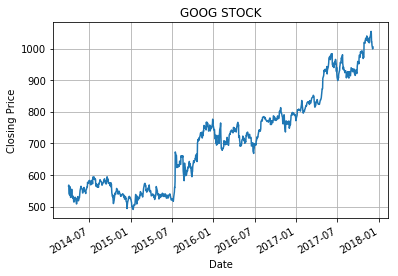

In [106]:
goog["Close"].plot(grid=True)
plt.ylabel("Closing Price")
plt.title("GOOG STOCK")
plt.show()

One of the most common needs for time-series data is resampling at a higher or lower frequency. This can be done using the `resample()` method, or using `asfreq()`. The primary difference is that, while `resample()` is fundamentally a data aggregation technique, `asfreq()` is a data selection method. 

For the google data, let's compare what both return when we down-sample the data:

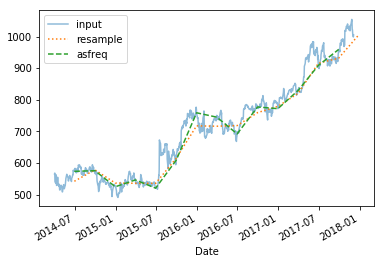

In [111]:
goog["Close"].plot(alpha=.5, style="-")
goog["Close"].resample("BQ").mean().plot(style=":")
goog["Close"].asfreq("BQ").plot(style="--")
plt.legend(["input", "resample", "asfreq"], loc="upper left")
plt.show()

Notice that `resample` reports the average of the previous year, whereas `asfreq` reports the value at the end of the year. 

For up-sampling, `resample()` and `asfreq()` are largely equivalent, although `resample()` has considerably more options. The default for both methods is to leave the up-sampled points empty, i.e NA values. We also have options to impute missing values.

## Method Chaining

You notice in one of the above examples of merging the wide-format into the whole dataset, we used function chaining to get what we wanted.

Let's say we wanted to perform a series of different operations on this data to obtain a more useful column/metric and output:

In [26]:
(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(['age_group','sex']).mean()
    .twstrs.unstack("sex")
    .fillna(0.0)
    .plot.barh(figsize=(10,5)))

## Pipes

One of the problems with method chaining is that it requires all of the functionality you need for data processing to be implemented somewhere as methods which return the actual DataFrame object in order to chain. Occasionally we want to do custom manipulations to our data, this is solved in *pipe*.

For example, we may wish to calculate the *proportion of twstrs* in the whole dataset to see differences between each patient in proportional terms across time to all of the other patients in their age group, their state of pain etc.

In [27]:
def to_proportions(df, axis=1):
    row_totals = df.sum(axis)
    return df.div(row_totals, True - axis)

(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(["week","age_group"]).mean()
    .twstrs.unstack("age_group")
    .pipe(to_proportions, axis=1))

age_group,"[0, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 90)"
week,,,,,,,,,,,,
0,0.077768,0.086100,0.090993,0.082132,0.078693,0.089248,0.087231,0.086857,0.077027,0.086563,0.090729,0.066658
2,0.109625,0.074226,0.104079,0.086025,0.081267,0.083198,0.091862,0.085873,0.080638,0.083075,0.085873,0.034258
4,0.062810,0.074888,0.102670,0.085481,0.088175,0.088900,0.096772,0.090262,0.085196,0.091497,0.094698,0.038652
8,0.080700,0.092696,0.089113,0.083385,0.082088,0.084907,0.095968,0.087442,0.082102,0.087244,0.097277,0.037079
12,0.074513,0.097672,0.085733,0.083962,0.076862,0.089694,0.091690,0.085497,0.084294,0.095155,0.090623,0.044305
16,0.078422,0.092100,0.086238,0.074634,0.075534,0.080489,0.092476,0.080743,0.080526,0.095064,0.089000,0.074774


We can now see the proportion of response variable across the age groups, per week.

## Data Transformation

We have several options for *transforming* labels and other columns into more useful features:

In [28]:
cdystonia.treat.replace({'Placebo': 0, "5000U": 1, "10000U": 2}).head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    2
7    2
8    2
9    2
Name: treat, dtype: int64

In [29]:
cdystonia.treat.astype("category").head(10)

0     5000U
1     5000U
2     5000U
3     5000U
4     5000U
5     5000U
6    10000U
7    10000U
8    10000U
9    10000U
Name: treat, dtype: category
Categories (3, object): [10000U, 5000U, Placebo]

In [30]:
pd.cut(cdystonia.age, [20,40,60,80], labels=["Young","Middle-Aged","Old"])[-25:]

606            Old
607            Old
608            Old
609            Old
610    Middle-Aged
611    Middle-Aged
612    Middle-Aged
613    Middle-Aged
614    Middle-Aged
615    Middle-Aged
616    Middle-Aged
617    Middle-Aged
618    Middle-Aged
619    Middle-Aged
620          Young
621          Young
622          Young
623          Young
624          Young
625          Young
626    Middle-Aged
627    Middle-Aged
628    Middle-Aged
629    Middle-Aged
630    Middle-Aged
Name: age, dtype: category
Categories (3, object): [Young < Middle-Aged < Old]

We can use qcut to automatically divide our data into even-sized $q$-tiles. For example $q=4$ refers to quartiles.

In [31]:
pd.qcut(cdystonia.age, 4)[-10:]

621    (25.999, 46.0]
622    (25.999, 46.0]
623    (25.999, 46.0]
624    (25.999, 46.0]
625    (25.999, 46.0]
626      (56.0, 65.0]
627      (56.0, 65.0]
628      (56.0, 65.0]
629      (56.0, 65.0]
630      (56.0, 65.0]
Name: age, dtype: category
Categories (4, interval[float64]): [(25.999, 46.0] < (46.0, 56.0] < (56.0, 65.0] < (65.0, 83.0]]

## Sparse Dataframes

*Sparse* version of Series and DataFrame are implemented in Pandas. They are not sparse in the typical sense, rather these objects are **compressed** where any data matching a specific value (`NaN`/missing) is omitted. A special `SparseIndex` object tracks where data has been *sparsified*. See this example:

In [32]:
ts = pd.Series(np.random.randn(10))
ts[2:-2] = np.nan
sts = ts.to_sparse()
sts

0    0.926576
1    1.276230
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8   -0.299473
9    2.566305
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

The `to_sparse()` method allows us to fill the value with something other than `NaN`:

In [33]:
ts.fillna(0.).to_sparse(fill_value=0)

0    0.926576
1    1.276230
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8   -0.299473
9    2.566305
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

These Sparse objects are mostly useful for memory-efficient reasons. Suppose you had a mostly `NaN` DataFrame:

In [34]:
df = pd.DataFrame(np.random.rand(100,100))
df_sp = df.where(df < 0.02).to_sparse()
print(df_sp.density)
df_sp.head()

0.0187


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
print("Memory usage [sparse]: %d bytes\nMemory usage [dense]: %d bytes" % (df_sp.memory_usage().sum(), df.memory_usage().sum()))

Memory usage [sparse]: 1576 bytes
Memory usage [dense]: 80080 bytes


Pandas also supports creating sparse dataframes directly from `scipy.sparse` matrices. It is worth mentioning that Pandas converts scipy matrices NOT in COOrdinate format to COO, copying data as needed. 

In [36]:
from scipy import sparse

scip_sps = sparse.coo_matrix(np.random.choice([0,1], size=(1000,1000), p=(.95, .05)))
scip_sps

<1000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 50157 stored elements in COOrdinate format>

In [37]:
sdf = pd.SparseDataFrame(scip_sps)
sdf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tasks

Recipe Database